# DevAx: Introduction to Gremlin

Gremlin is a graph traversal machine and language designed, developed, and distributed by the [Apache TinkerPop](https://tinkerpop.apache.org/) project. Apache TinkerPop is a graph computing framework and top level project hosted by the Apache Software Foundation. Any TinkerPop enabled graph databases can be accessed using the Gremlin query language. As an explanatory analogy, Apache TinkerPop and Gremlin are to graph databases what the JDBC and SQL are to relational databases.

## Introducing the air-routes graph

The air-routes graph is a model of the worldwide air route network. There are vertices for airports, countries and continents. There are edges between airports and between the countries, continents and airports.

Routes between airports are modeled as edges. These edges carry the route label and include the distance between the two connected airport vertices as a property called dist. Connections between countries and airports are modelled using an edge with a contains label.

Each airport vertex has many properties associated with it giving various details about that airport including its IATA and ICAO codes, its description, the city it is in and its geographic location.

Specifically, each airport vertex has a unique ID, a label of airport and contains the following properties. The word in parenthesis indicates the type of the property.

```
 type    (string) : Vertex type. Will be 'airport' for airport vertices
 code    (string) : The three letter IATA code like AUS or LHR
 icao    (string) : The four letter ICAO code or none. Example KAUS or EGLL
 desc    (string) : A text description of the airport
 region  (string) : The geographical region like US-TX or GB-ENG
 runways (int)    : The number of available runways
 longest (int)    : Length of the longest runway in feet
 elev    (int)    : Elevation in feet above sea level
 country (string) : Two letter ISO country code such as US, FR or DE.
 city    (string) : The name of the city the airport is in
 lat     (double) : Latitude of the airport
 lon     (double) : Longitude of the airport
```

You can find the data set at the following GitHub repository: https://github.com/krlawrence/graph

## Loading some sample data

The Neptune workbench has a `%seed` command that you can use to load the sample data that the queries in this post will use. Simply create a new cell in your notebook, enter `%seed` and run the cell. You will be promted for the "Language" (graph type) and "Data set" you want to use. In this lab we are going to look at Gremlin queries. Select the "airports" data. Once you click on "Submit" the data will start to load. Loading the data should only take a few seconds.

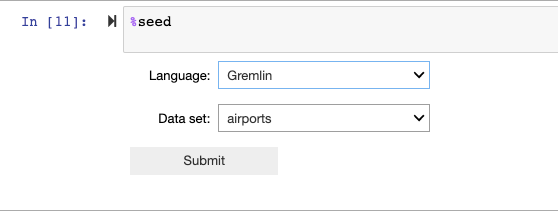

## Writing Gremlin queries
A graph query is often referred to as a traversal as that is what we are in fact doing. We are traversing the graph from a starting point to an ending point. Traversals consist of one or more steps (essentially methods) that are chained together. Every step is either a map-step (transforming the objects in the stream), a filter-step (removing objects from the stream), or a sideEffect-step (computing statistics about the stream). 

The first step is to create a graph traversal source object for our loaded graph.

```
g = graph.traversal()
```

If you were using Python to connect to Neptune, you would need to install `gremlinpython` library. Below is an example of running a simple query.

```
from __future__  import print_function  # Python 2/3 compatibility

from gremlin_python import statics
from gremlin_python.structure.graph import Graph
from gremlin_python.process.graph_traversal import __
from gremlin_python.process.strategies import *
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection

graph = Graph()

remoteConn = DriverRemoteConnection('wss://your-neptune-endpoint:8182/gremlin','g')
g = graph.traversal().withRemote(remoteConn)

print(g.V().limit(2).toList())
remoteConn.close()
```

But we can avoid this by using [Neptune workbench magic commands](https://docs.aws.amazon.com/neptune/latest/userguide/notebooks-magics.html). The `%%gremlin` cell magic issues a Gremlin query to the Neptune endpoint using WebSocket. It accepts an optional line input to toggle into Gremlin explain mode or Gremlin profile API, and a separate optional visualization hint input to modify visualization output behavior.

Once we have a graph traversal source object we can use it to start exploring the graph. The V step returns vertices and the E step returns edges. You can also use a V step in the middle of a traversal as well as at the start but we will examine those uses a little later. The V and E steps can also take parameters indicating which set of vertices or edges we are interested in.

The other steps we need to introduce are the `has` and `hasLabel` steps. They can be used to test for a certain label or property having a certain value. We are good to get started!

**1. Return the vertex that represents Singapore (SIN) airport**

In [ ]:
%%gremlin
g.V().hasLabel('airport').has('code','SIN')

In [ ]:
%%gremlin
g.V().has('airport','code','SIN')

**2. Get the properties of SIN vertex**

In [ ]:
%%gremlin
g.V().has('airport','code','SIN').valueMap()

In [ ]:
%%gremlin
g.V().has('airport','code','SIN').valueMap().select('lat','lon')

**3. Counting: How many airports are in the graph?**

In [ ]:
%%gremlin
g.V().hasLabel('airport').count()

**4. Counting by groups: How many of each type of vertex are there?**

In [ ]:
%%gremlin
g.V().groupCount().by(label)

In [ ]:
%%gremlin
g.E().label().groupCount()

In [ ]:
%%gremlin
g.E().group().by(label).by(count())

**5. Counting by groups: How many airports are there in each country?**

In [ ]:
%%gremlin
g.V().hasLabel('airport').groupCount().by('country')

In [ ]:
%%gremlin
g.V().hasLabel('airport').groupCount().by('country').select('SG','FR')

## Starting to walk the graph
The term *walking the graph* is used to describe moving from one vertex to another vertex via an edge. Typically when using the phrase walking a graph the intent is to describe starting at a vertex traversing one or more vertices and edges and ending up at a different vertex or sometimes, back where you started in the case of a circular walk. The journey we take while on our *walk* is often referred to as our *path*. There are also cases when all you want to do is return edges or some combination of vertices and edges as the result of a query and Gremlin allows this as well.

The table below gives a brief summary of all the steps that can be used to walk or traverse a graph using Gremlin.

|**Step**|**Where to move next** |
|:------ | :---------------------- |
|out*    |Outgoing adjacent vertices.|
|in*     |Incoming adjacent vertices.|
|both*   |Both incoming and outgoing adjacent vertices.|
|outE*   |Outgoing incident edges.|
|inE*    |Incoming incident edges.|
|bothE*  |Both outgoing and incoming incident edges.|
|outV    |Outgoing vertex.|
|inV     |Incoming vertex.|
|otherV* |The vertex that was not the vertex we came from.|

The steps labelled with an * can optionally take the name of one or more edge labels as a parameter. If omitted, all relevant edges will be traversed.

**6. Traversal: Where can I fly to from Singapore?**

In [ ]:
%%gremlin
g.V().has('airport','code','SIN').out().values('city')

**7. Traversal: Where can I fly to from Singapore that is one stop away?**

In [ ]:
%%gremlin
g.V().has('airport','code','SIN').out().out().dedup().values('code')

In [ ]:
%%gremlin
g.V().
    has('airport','code','SIN').
    out().
    out().
    dedup().
    not(cyclicPath()).
    values('code')

In [ ]:
%%gremlin
g.V().
    has('airport','code','SIN').as('origin').
    out().
    out().
    where(neq('origin')).
    dedup().
    values('code')

**8. Traversal: Flights from Singapore to US**

In [ ]:
%%gremlin
g.V().
    has('airport','country','SG').
    out().
    has('country','US').
    values('city')

### Introducing path
After you have done some graph walking using a query you can use path to get a summary back of where you went. 

**9. Path: Return the vertices and outgoing edges starting at the London City (LCY) airport vertex.** 

You can read this query like this: "Start at the LCY vertex, find all outgoing edges and also find all of the vertices that are on the other ends of those edges". The inV step gives us the vertex at the other end of the outgoing edge.

In [ ]:
%%gremlin
g.V().
    has('airport','code','LCY').
    outE().
    inV().
    path().
    limit(10)


## Seeing a visual representation of your Gremlin queries

The results of any Gremlin query that returns a `path` can be explored visually. When such queries are run you will see a `Graph` tab in the query results area alongside the `Console` tab. As Gremlin queries allow for `by` modulators to be used to modify the representation of `path` results, there are some rules concerning how results will be rendered visually. These rules are worth remembering. The default behavior for vertex and edge `path` results that are not modified using `by` modulators is to use their labels to annotate the visualization.

In some cases, the Neptune Notebook visualizer can figure out for itself whether an element in a `path` result represents a vertex or an edge and, in some cases, the direction the edge follows. Two simple examples of such queries are shown below. As the first query does not contain any edge information in the `path` result the edge direction cannot be determined automatically by the visualizer. 

`g.V().hasLabel('airport').out().path().limit(5)`  

In this case, the edge direction can be determined as there is an `outE` step included in the query.

`g.V().hasLabel('airport').outE().inV().path().limit(5)`

When no `by` modulators are provided, the visualizer will use the vertex and edge labels to annotate the elements of the diagram. However, when `by` modulators are used, it is not possible for the visualizer in all cases to decide on its own which path elements represent a vertex and which represent an edge. Here is an example of such a query:  

`g.V().hasLabel('airport').outE().inV().path().by('code').by('dist').limit(5)`

It is also not always possible for the visualizer to decide which direction an edge follows. In this case and in the case where `by` modulators are used, the visualizer allows for some special hints to be provided to assist in producing the desired diagram.

### Query visualization hints

You can specify query visualization hints using either `-p` or `--path-pattern` after the `%%gremin` cell "magic". The syntax in general is:

`%%gremlin -p | --path-pattern <comma separated hints>`

 The names of the hints reflect the Gremlin steps most commonly used when traversing between vertices and behave accordingly. The hints used should match the corresponding Gremlin steps used in the query. The hints used can be any combination of those shown in the list below, separated by commas. The list must not contain any spaces between the commas.

- v
- inv
- outv
- e
- ine
- oute



We can provide visualization hints for the query shown earlier as follows:

`%%gremlin -p v,oute,inv`  
`g.V().has('airport','code','LCY').outE().inV().path().by('code').by('dist').limit(5)`

If you were to run the query with and without the hints present you would observe the differences. Without the hint the visualizer is unable to determine if the `dist` property relates to a vertex or an edge and therefore defaults to using a vertex.


In [ ]:
%%gremlin -p v,oute,inv 
g.V().has('airport','code','LCY').outE().inV().path().by('city').by('dist').limit(5)


### Introducing the Details view
If your Gremlin query results include a key/value map, as generated by the `valueMap` step, you can hover the mouse over a vertex to see many of the results but it is sometimes nicer to see them in a table. Clicking on a vertex and then selecting the Details view icon will pop up a table showing a nice scrollable list of the results. You can move the pop up window around and make it larger or smaller as suits your preference. The following Gremlin query was used to produce these results.


In [ ]:
%%gremlin -p v,oute,inv
g.V().has('airport','code','SIN').outE().inV().
  path().
    by(valueMap('code','city','region','desc','lat','lon').order(local).by(keys)).
    by('dist').limit(10)

### Routes between New Zealand and Australia
The last Gremlin query we are going to look at for now produces a more interesting result. 

**10. Find all routes that start in New Zealand and end in Australia.**

The Gremlin query below does just that. When we run the query and look at the resultant diagram we can see all the different ways New Zealand and Australia are connected within the data set.

In [ ]:
%%gremlin -p v,inv
g.V().
    has('airport','country','NZ').
    out('route').
    has('country','AU').
    path().
    by('city')

## Summary

We have looked at some basic Gremlin queries and how to visualize the results using Neptune Workbench

## References

1. https://kelvinlawrence.net/book/Gremlin-Graph-Guide.html#tpintro
2. https://tinkerpop.apache.org/gremlin.html
